# CE-40719: Deep Learning
## HW5 - GAN (100 points)

#### Name: AmirHossein Mohammadi
#### Student No.: 99201081

### 1) Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3) # set default size of plots

### 2) Loading Dataset (10 points)

In this notebook, you will use `MNIST` dataset to train your GAN. You can see more information about this dataset [here](http://yann.lecun.com/exdb/mnist/). This dataset is a 10 class dataset. It contains 60000 grayscale images (50000 for train and 10000 for test or validation) each with shape (3, 28, 28). Every image has a corresponding label which is a number in range 0 to 9.

In [2]:
# MNIST Dataset
img_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./mnist/', train=True, transform=img_transform, download=True)
test_dataset = datasets.MNIST(root='./mnist/', train=False, transform=img_transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

################ Problem 01 (5 pts) ################
# define hyper parameters
batch_size = 64
d_lr = 2e-4
g_lr = 2e-4
n_epochs = 20
####################### End ########################
z_dim = 100

In [4]:

################ Problem 02 (5 pts) ################
# Define Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
####################### End ########################


### 3) Defining Network (30 points)
At this stage, you should define a network that improves your GAN training and prevents problems such as mode collapse and vanishing gradients.

In [20]:
class Discriminator(nn.Module):
    def __init__(self,d=8):
        super().__init__()

        self.discriminator = nn.Sequential(
            ################ Problem 03 (15 pts) ################
            # use linear or convolutional layer
            # use arbitrary techniques to stabilize training
            nn.Conv2d(1, d, 4, 2, 1),
            nn.LeakyReLU(),
            nn.Conv2d(d, d*2, 4, 2, 1),
            nn.BatchNorm2d(d*2),
            nn.LeakyReLU(),
            nn.Conv2d(d*2, d*4, 4, 2, 1),
            nn.BatchNorm2d(d*4),
            nn.LeakyReLU(),
            nn.Conv2d(d*4, d*8, 4, 2, 1),
            nn.BatchNorm2d(d*8),
            nn.LeakyReLU(),
            nn.Conv2d(d*8, 1, 4, 1, 0),
            nn.Sigmoid()
            ####################### End ########################
        )

    def forward(self, x):
        return self.discriminator(x)


class Generator(nn.Module):
    def __init__(self,d=8):
        super().__init__()

        self.generator = nn.Sequential(
            ################ Problem 04 (15 pts) ################
            # use linear or convolutional layer
            # use arbitrary techniques to stabilize training
            nn.ConvTranspose2d(100, d*8, 4, 1, 0),
            nn.BatchNorm2d(d*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(d*8, d*4, 4, 2, 1),
            nn.BatchNorm2d(d*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(d*4, d*2, 4, 2, 1),
            nn.BatchNorm2d(d*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(d*2, d, 4, 2, 1),
            nn.BatchNorm2d(d),
            nn.ReLU(True),
            nn.ConvTranspose2d(d, 1, 4, 2, 1),
            nn.Tanh()
            ####################### End ########################
        )

    def forward(self, z):
        return self.generator(z)


In [21]:
generator = Generator()
generator

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(8, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [22]:
discriminator = Discriminator()
discriminator

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

### 4) Train the Network 
At this step, you are going to train your network.

In [23]:
################ Problem 05 (5 pts) ################
# Create instances of modules (discriminator and generator)
# don't forget to put your models on device
discriminator = Discriminator()
generator = Generator()
generator = generator.to(device)
discriminator = discriminator.to(device)
num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
####################### End ########################

In [24]:
################ Problem 06 (5 pts) ################
# Define two optimizer for discriminator and generator
d_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(params=generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
####################### End ########################

Training ...
epoch: 1 	 discriminator last batch loss: 0.0005776322796009481 	 generator last batch loss: 7.721209526062012
epoch: 1 average loss generator vs. discrim.: 5.876743 vs. 0.019918


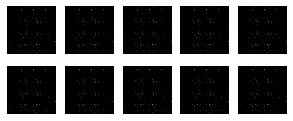

epoch: 2 	 discriminator last batch loss: 0.024225549772381783 	 generator last batch loss: 4.440528869628906
epoch: 2 average loss generator vs. discrim.: 8.046403 vs. 0.008831


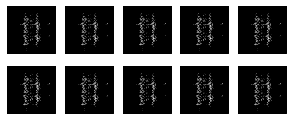

epoch: 3 	 discriminator last batch loss: 0.014510626904666424 	 generator last batch loss: 4.755619049072266
epoch: 3 average loss generator vs. discrim.: 4.739024 vs. 0.048823


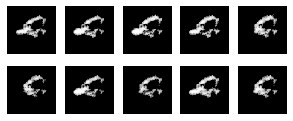

epoch: 4 	 discriminator last batch loss: 0.0050324732437729836 	 generator last batch loss: 5.33470344543457
epoch: 4 average loss generator vs. discrim.: 5.188027 vs. 0.014701


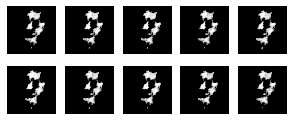

epoch: 5 	 discriminator last batch loss: 0.1579645872116089 	 generator last batch loss: 3.9011969566345215
epoch: 5 average loss generator vs. discrim.: 5.785724 vs. 0.028526


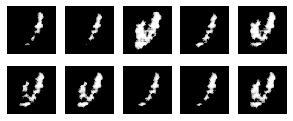

epoch: 6 	 discriminator last batch loss: 0.12367105484008789 	 generator last batch loss: 5.683967590332031
epoch: 6 average loss generator vs. discrim.: 4.202296 vs. 0.086433


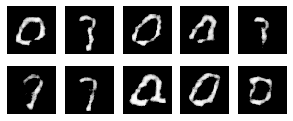

epoch: 7 	 discriminator last batch loss: 0.01706363447010517 	 generator last batch loss: 2.92220139503479
epoch: 7 average loss generator vs. discrim.: 4.337529 vs. 0.056254


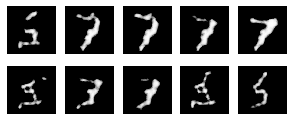

epoch: 8 	 discriminator last batch loss: 0.05860573798418045 	 generator last batch loss: 2.8676228523254395
epoch: 8 average loss generator vs. discrim.: 4.754058 vs. 0.042417


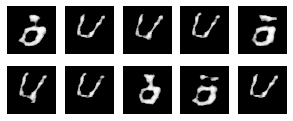

epoch: 9 	 discriminator last batch loss: 0.014919375069439411 	 generator last batch loss: 7.797720432281494
epoch: 9 average loss generator vs. discrim.: 4.951491 vs. 0.033236


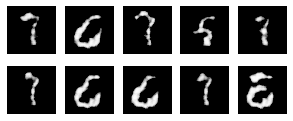

epoch: 10 	 discriminator last batch loss: 0.04833817481994629 	 generator last batch loss: 7.233254432678223
epoch: 10 average loss generator vs. discrim.: 4.993389 vs. 0.029124


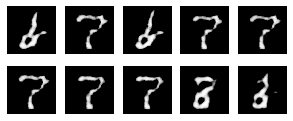

epoch: 11 	 discriminator last batch loss: 0.0383148230612278 	 generator last batch loss: 4.751415729522705
epoch: 11 average loss generator vs. discrim.: 5.097154 vs. 0.044041


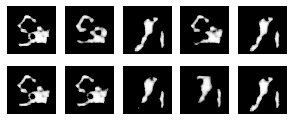

epoch: 12 	 discriminator last batch loss: 0.021783122792840004 	 generator last batch loss: 4.41020393371582
epoch: 12 average loss generator vs. discrim.: 4.826338 vs. 0.039260


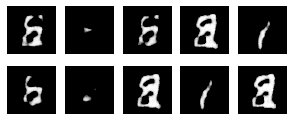

epoch: 13 	 discriminator last batch loss: 0.04180270433425903 	 generator last batch loss: 4.572174072265625
epoch: 13 average loss generator vs. discrim.: 4.937386 vs. 0.038590


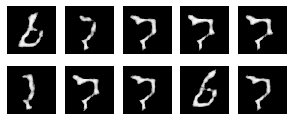

epoch: 14 	 discriminator last batch loss: 0.14902639389038086 	 generator last batch loss: 6.500872611999512
epoch: 14 average loss generator vs. discrim.: 5.121131 vs. 0.034596


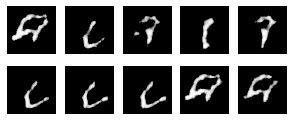

epoch: 15 	 discriminator last batch loss: 0.016810506582260132 	 generator last batch loss: 4.986096382141113
epoch: 15 average loss generator vs. discrim.: 5.226300 vs. 0.028203


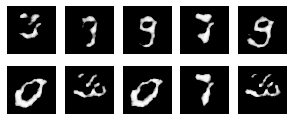

epoch: 16 	 discriminator last batch loss: 0.031085293740034103 	 generator last batch loss: 7.195932388305664
epoch: 16 average loss generator vs. discrim.: 5.498429 vs. 0.017770


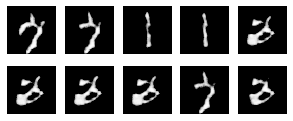

epoch: 17 	 discriminator last batch loss: 0.015072716400027275 	 generator last batch loss: 5.2267961502075195
epoch: 17 average loss generator vs. discrim.: 5.518928 vs. 0.029672


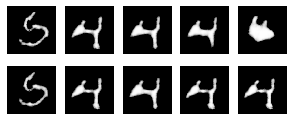

epoch: 18 	 discriminator last batch loss: 0.04375818744301796 	 generator last batch loss: 4.624922752380371
epoch: 18 average loss generator vs. discrim.: 5.696372 vs. 0.033975


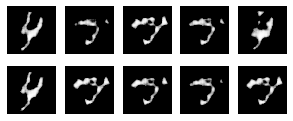

epoch: 19 	 discriminator last batch loss: 0.002357092685997486 	 generator last batch loss: 6.522910118103027
epoch: 19 average loss generator vs. discrim.: 5.415425 vs. 0.015003


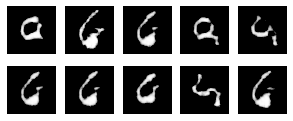

epoch: 20 	 discriminator last batch loss: 0.013445207849144936 	 generator last batch loss: 5.6248674392700195
epoch: 20 average loss generator vs. discrim.: 5.810553 vs. 0.026543


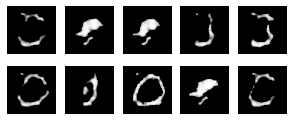

Finished :)


In [25]:
generator.train()
discriminator.train()
g_loss_avg = []
d_loss_avg = []
print('Training ...')
for epoch in range(n_epochs):
    g_loss_avg.append(0)
    d_loss_avg.append(0)
    num_batches = 0
    for images, _ in train_loader:
        ################ Problem 07 (15 pts) ################
        # put your inputs on device
        # Prepare what you need for training, like inputs for modules and variables for computing loss
        images = images.to(device)
        label_real = torch.ones(images.size(0), device=device)
        label_fake = torch.zeros(images.size(0), device=device)
        z = torch.randn(images.size(0), z_dim, 1, 1, device=device)
        fake_images = generator(z)
        real_pred = discriminator(images).squeeze()
        fake_pred = discriminator(fake_images.detach()).squeeze()

        ####################### End ########################



        ################ Problem 08 (10 pts) ################
        # calculate discriminator loss and update it
        d_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        ####################### End ########################
        
        

        ################ Problem 09 (10 pts) ################
        # calculate generator loss and update it
        fake_pred = discriminator(fake_images).squeeze()
        g_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        ####################### End ########################


    ################ Problem 10 (10 pts) ################
    # plot some of the generated pictures based on plot frequency variable
        g_loss_avg[-1] += g_loss.item()
        d_loss_avg[-1] += d_loss.item()
        num_batches += 1
        
    g_loss_avg[-1] /= num_batches
    d_loss_avg[-1] /= num_batches
    print("epoch: {} \t discriminator last batch loss: {} \t generator last batch loss: {}".format(epoch + 1, 
                                                                                            d_loss.item(), 
                                                                                            g_loss.item())
    )
    print('epoch: %d average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, g_loss_avg[-1], d_loss_avg[-1]))
    fakeimg = fake_images.detach().cpu()
    fakeimg = fakeimg.view(-1, 64, 64)
    fakeimg = fakeimg.numpy()
    cols = 5
    plt.rcParams['figure.figsize'] = (cols, 2)
    for i in range(10):
        plt.subplot(2, cols, i + 1)
        plt.imshow(fakeimg[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()
    ####################### End ########################
print('Finished :)')

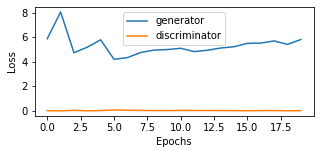

In [27]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(g_loss_avg, label='generator')
plt.plot(d_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 5) Save Generator
Save your final generator parameters. Upload it with your other files.

In [26]:
################ Problem 11 (5 pts) ################
# save state dict of your generator
torch.save(generator.state_dict(), 'generator.pth')
####################### End ########################